# Environment Setup 

In [2]:
#!pip install python==3.6


In [3]:
from platform import python_version
print(python_version())

3.6.9


In [4]:
#!pip install tensorflow==1.13.1

In [5]:
!pip show tensorflow

Name: tensorflow
Version: 2.4.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: opt-einsum, protobuf, typing-extensions, numpy, six, termcolor, wrapt, gast, google-pasta, astunparse, wheel, tensorboard, flatbuffers, h5py, keras-preprocessing, absl-py, tensorflow-estimator, grpcio
Required-by: fancyimpute


In [6]:
#!pip install Keras==2.3.1

In [7]:
!pip show keras

Name: Keras
Version: 2.4.3
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, pyyaml, numpy, h5py
Required-by: textgenrnn, keras-vis, kapre, fancyimpute


# Importing Libraries

In [8]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [9]:
# Importing Libraries
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping


RANDOM_SEED = 123

# Loading Dataset from Kaggle

In [10]:
#Reading Data from Kaggel
! pip install -q kaggle
! mkdir ~/.kaggle 
! cp /content/drive/MyDrive/DataSet/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
# downloading
! kaggle datasets download -d ahmedhamada0/brain-tumor-detection

 95% 61.0M/64.1M [00:00<00:00, 51.7MB/s]
100% 64.1M/64.1M [00:00<00:00, 69.6MB/s]


In [12]:
#Unziping Dataset
! unzip "brain-tumor-detection.zip" -d "brain_tumor_dataset"
clear_output()

In [13]:
# Deleting pred Folder Because we dont need it right now.
  
# location 
location = "/content/brain_tumor_dataset"
  
# directory 
dir = "pred"
  
# path 
path = os.path.join(location, dir) 
  
# removing directory 
shutil.rmtree(path) 

# Spliting the Dataset

In [14]:
# TRAIN-VALIDATION SPLIT (80% TRAIN - 15% VALIDATION - 5% TEST)

! pip install split_folders
clear_output()

import splitfolders
input_folder = "/content/brain_tumor_dataset/"
output = ""

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .15, .05))

Copying files: 3000 files [00:00, 8447.71 files/s]


In [15]:
# Splitting into X & y

def load_data(dir_path, img_size=(100,100)):
  '''Load resized image as np.arrays to workspace'''
  X = []
  y = []
  i = 0
  labels = dict()
  for path in tqdm(sorted(os.listdir(dir_path))):
    if not path.startswith('.'):
      labels[i] = path
      for file in os.listdir(dir_path + path):
        if not file.startswith('.'):
          img = cv2.imread(dir_path + path + '/' + file)
          X.append(img)
          y.append(i)
      i += 1
  X = np.array(X)
  y = np.array(y)
  print(f'{len(X)} images loaded from {dir_path} directory.')
  return X, y, labels


In [16]:
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'
VAL_DIR = 'val/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:04<00:00,  2.13s/it]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  0%|          | 0/2 [00:00<?, ?it/s]

2400 images loaded from train/ directory.


  0%|          | 0/2 [00:00<?, ?it/s]

150 images loaded from test/ directory.


100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

450 images loaded from val/ directory.


# Data Preprocessing

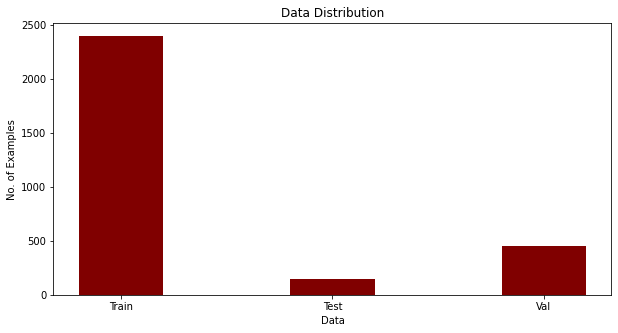

In [17]:
size_data = [len(X_train), len(X_test), len(X_val)]
name_data = ["Train", "Test","Val"]
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(name_data, size_data, color ='maroon',  
        width = 0.4) 
  
plt.xlabel("Data") 
plt.ylabel("No. of Examples") 
plt.title("Data Distribution") 
plt.show() 

In [18]:
def plot_samples(X,y,labels_dict,n=50):
  '''Create a gridplot for desired number of image (n) from the specified set '''
  for index in range(len(labels_dict)):
    imgs = X[np.argwhere(y == index)][:n]
    j = 10
    i = int(n/j)

    plt.figure(figsize=(15,6))
    c = 1
    for img in imgs:
      plt.subplot(i,j,c)
      plt.imshow(img[0])
      plt.xticks([])
      plt.yticks([])
      c+=1
    plt.suptitle('Tumor: {}'.format(labels_dict[index]))
    plt.show()

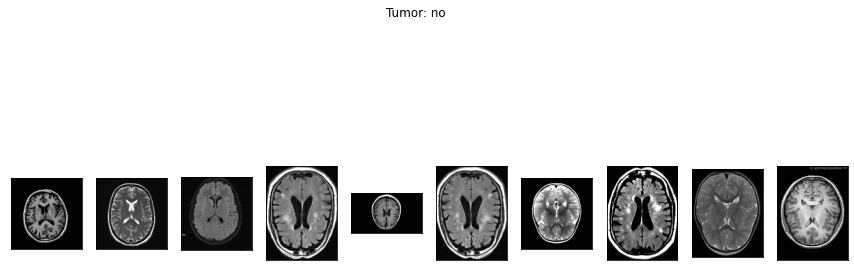

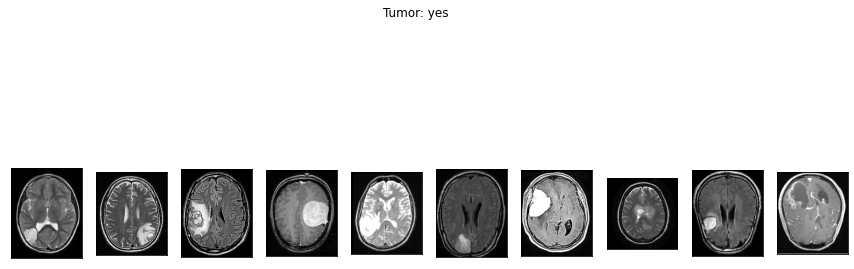

In [19]:
plot_samples(X_train,y_train,labels,10)

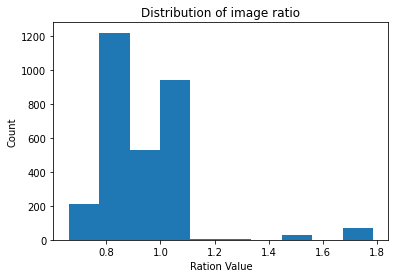

In [20]:
#Histogram for ratio distribution of image size
Ratio_list = []
for set in (X_train, X_test, X_val):
  for img in set:
    Ratio_list.append(img.shape[1]/img.shape[0])

plt.hist(Ratio_list)
plt.title('Distribution of image ratio')
plt.xlabel('Ration Value')
plt.ylabel('Count')
plt.show()

In [21]:
#Function to crop image
def crop_imgs(set_name, add_pixels_value=0):
  '''
      Finds the extreme points on the image and crops the rectangular out of them
  '''
  set_new = []
  for img in set_name:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray,(5,5),0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray,45,255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cntrs = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntrs = imutils.grab_contours(cntrs)
    c = max(cntrs, key=cv2.contourArea)

    #find the extreme points
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    Add_pixels = add_pixels_value
    new_img = img[extTop[1]-Add_pixels:extBot[1]+Add_pixels, extLeft[0]-Add_pixels:extRight[0]+Add_pixels].copy()

    set_new.append(new_img)
  
  return np.array(set_new)

In [22]:
#Let's look at example what this function will do with MRI scans:
img = cv2.imread('/content/brain_tumor_dataset/yes/y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

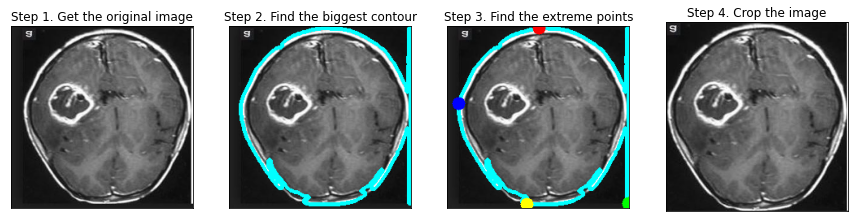

In [23]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [24]:
# Now lets apply for each set
X_train_crop = crop_imgs(set_name=X_train)
X_test_crop = crop_imgs(set_name=X_test)
X_val_crop = crop_imgs(set_name=X_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


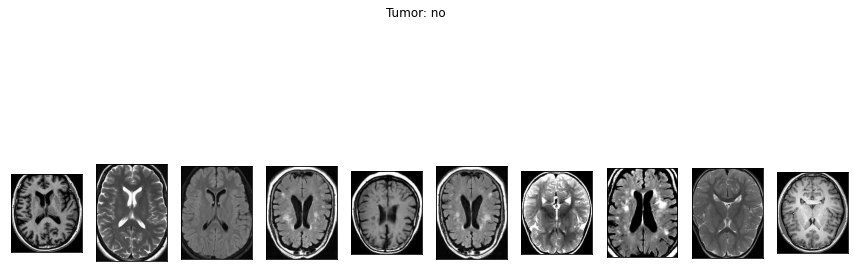

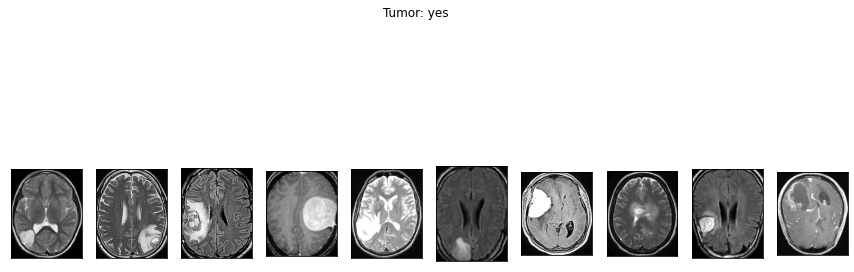

In [25]:
plot_samples(X_train_crop,y_train,labels,10)

In [26]:
def save_new_images(x_set, y_set, folder_name):
  i=0
  for (img, imclass) in zip(x_set, y_set):
    if imclass ==0:
      cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
    else:
      cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
    i += 1

In [27]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [28]:
#The next step would be resizing images to (224,224) and applying preprocessing needed for VGG-16 model input.

def preprocess_imgs(set_name, img_size):
  '''
  Resize and apply VGG16 preprocessing
  '''
  set_new = []
  for img in set_name:
    img = cv2.resize(img,
                     dsize=img_size,
                     interpolation=cv2.INTER_CUBIC)
    
    #Remember preprocess_input we had already imported for vgg16.
    set_new.append(preprocess_input(img))
  return np.array(set_new)

In [29]:
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

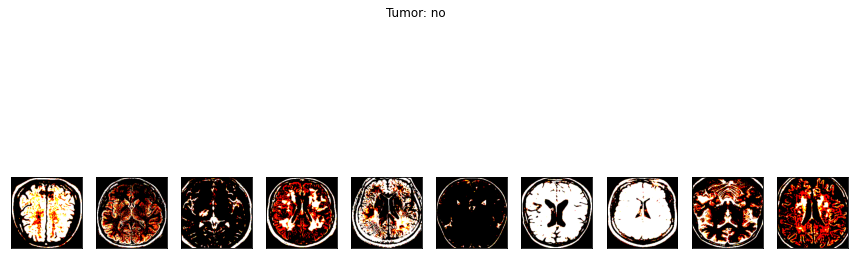

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

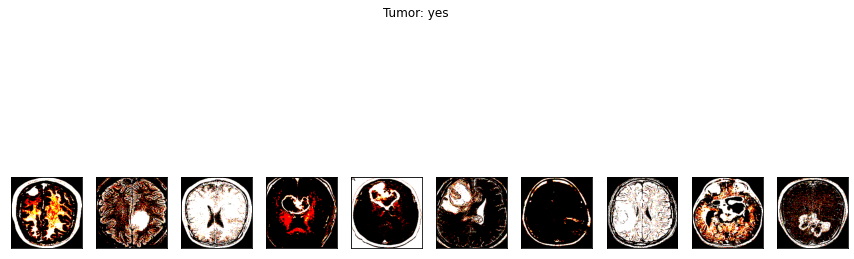

In [30]:
plot_samples(X_test_prep,y_test,labels,10)

# Data Augmentation

In [ ]:
Train_dir = 'TRAIN_CROP/'
Val_dir = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5,1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_gen = train_datagen.flow_from_directory(
    Train_dir,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)
val_gen = test_datagen.flow_from_directory(
    Val_dir,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 2400 images belonging to 2 classes.
Found 450 images belonging to 2 classes.


# Model building

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
import tensorflow
IMAGE_SIZE=[224,224]
vgg = tensorflow.keras.applications.VGG16(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# don't train the layers
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of output classes
from glob import glob
folders = glob('/content/TRAIN_CROP/*')

In [ ]:
# Our layer
x = Flatten()(vgg.output)
output = Dense(len(folders), activation='sigmoid')(x)

In [ ]:
# create a model object
model = Model(inputs=vgg.input, outputs=output)

In [ ]:
# View the Structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# compiling the model with cost and optimizir
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from keras.callbacks import ModelCheckpoint
bach_size = 32

# Checkpoint to store the best model
checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')


vgg16_history = model.fit(train_gen,
    steps_per_epoch=2400//bach_size,
    epochs=50,
    validation_data=val_gen,
    validation_steps=450//bach_size,
    callbacks=[checkpoint])




Epoch 1/50
75/75 [==============================] - 37s 489ms/step - loss: 1.5963 - accuracy: 0.9125 - val_loss: 3.8123 - val_accuracy: 0.8728

Epoch 00001: val_loss improved from inf to 3.81230, saving model to model-001-0.912500-0.872768.h5
Epoch 2/50
75/75 [==============================] - 37s 493ms/step - loss: 1.5089 - accuracy: 0.9367 - val_loss: 0.5933 - val_accuracy: 0.9621

Epoch 00002: val_loss improved from 3.81230 to 0.59326, saving model to model-002-0.936667-0.962054.h5
Epoch 3/50
75/75 [==============================] - 37s 489ms/step - loss: 1.8258 - accuracy: 0.9292 - val_loss: 0.9149 - val_accuracy: 0.9576

Epoch 00003: val_loss did not improve from 0.59326
Epoch 4/50
75/75 [==============================] - 37s 490ms/step - loss: 1.5861 - accuracy: 0.9346 - val_loss: 1.0247 - val_accuracy: 0.9464

Epoch 00004: val_loss did not improve from 0.59326
Epoch 5/50
75/75 [==============================] - 36s 486ms/step - loss: 1.3009 - accuracy: 0.9496 - val_loss: 2.2345 

# Loading and Evalutating Model

In [1]:
from tensorflow import keras
from keras.models import load_model
model = load_model('/content/model-014-0.975417-0.982143.h5')

In [31]:
predictions = model.predict(X_test_prep)

In [32]:
y_classes = predictions.argmax(axis=-1)

In [33]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_classes)
print('Accuracy: %f' % accuracy)

Accuracy: 1.000000


In [34]:
cv2.__version__

'4.1.2'